In [143]:
import numpy as np
import random as r
%matplotlib inline
import matplotlib.pyplot as plt # side-stepping mpl backend


def plot(**kwargs):
    count = len(kwargs)
    
    fig, axes = plt.subplots(count, 1, sharex=True,figsize=(12,count))

   

    axes[-1].set_xlabel('time') # x label


    c = 0
    
    for k, v in kwargs.items():
        ax = axes[c]
        c+=1
        color = f'C{c}'
        
        if len(v.shape)==1:
            ax.step(time,v, color)
        else:
            ax.imshow(v.T, interpolation='none', aspect='auto')
        ax.set_ylabel(k, c=color)
        

    _=plt.show()
    
def ones(value):
    n = 0
    while value:
        n += 1
        value &= value-1
    return n

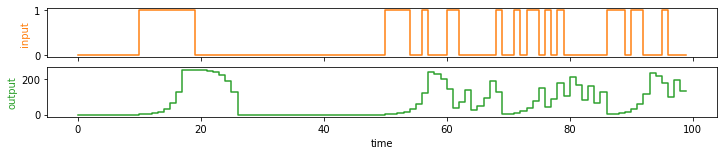

In [144]:
# sliding decay
TIME=100
time=np.arange(0,TIME,1)
I=np.zeros(TIME)
O=np.zeros(TIME)

potential = 0
MASK = (1<<8)-1

for t in time:

    potential = (potential << 1) & MASK
    if (t > 10 and t < 20) or (t > 50 and r.random()>0.5):
        I[t]=1
        potential |= 1

    O[t] = potential

plot(input=I, output=O)

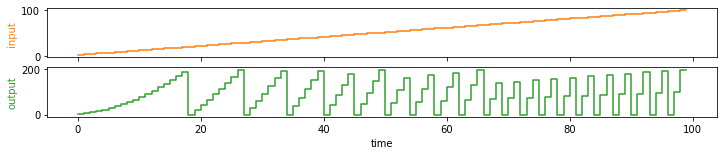

In [146]:
# secondary effects
TIME=100
time=np.arange(0,TIME,1)
I=np.zeros(TIME)
O=np.zeros(TIME)

channels = 0
potential = 0
delta=1

for t in time:

    channels += delta
    potential += channels
    if potential > 200:
        potential = 0

    I[t] = channels    
    O[t] = potential

plot(input=I, output=O)

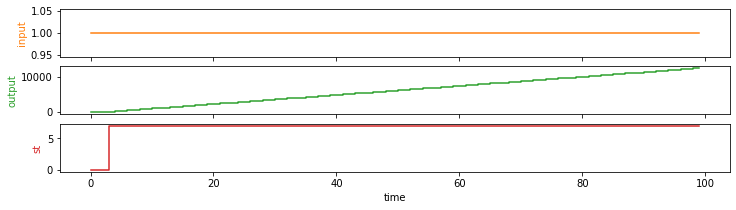

In [147]:
# NaV channels go through deactivated -> activated -> inactivated -> deactivated
# ready -> open -> disabled -> ready

BITS = 7
MASK = (1<<BITS)-1
open_state = 0
stop_state = 0

TIME=100
time=np.arange(0,TIME,1)
I=np.zeros(TIME)
O=np.zeros(TIME)
st=np.zeros(TIME)
potential = 0

for t in time:
    I[t] = 1
    
    potential += 1
    
    
    
    if potential > 4:
        open_state = (~stop_state & MASK)
    st[t]=ones(open_state)
    potential += open_state

    O[t] = potential
    
    open_state = (open_state << 1) & MASK

plot(input=I, output=O, st=st)


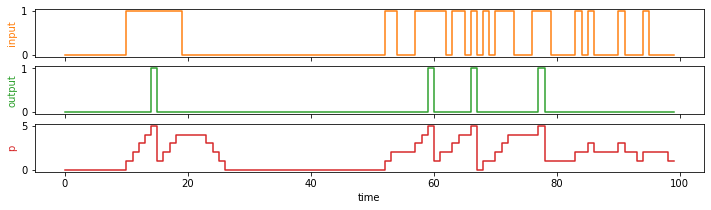

In [148]:
time=np.arange(0,100,1)
size = ((len(time)))
I=np.zeros(size)
O=np.zeros(size)

p=np.zeros(size)

potential = 0

MASK = (1<<8)-1

for t in time:

    potential = (potential << 1) & MASK
    if (t > 10 and t < 20) or (t > 50 and r.random()>0.5):
        I[t]=1
        potential |= 1

    p[t] = ones(potential)        
    if ones(potential) > 4:
        O[t]=1
        potential=0


plot(input=I, output=O, p=p)

# Introduce hyperpolarization

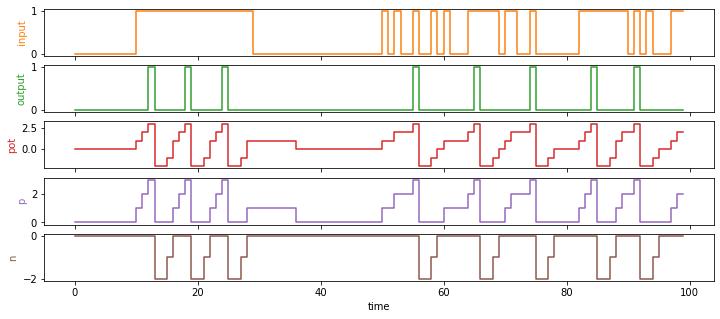

In [149]:
time=np.arange(0,100,1)
size = ((len(time)))
I=np.zeros(size)
O=np.zeros(size)

pot=np.zeros(size)
p=np.zeros(size)
n=np.zeros(size)


pos = 0
neg = 0

MASK = (1<<8)-1
NEGMASK = (1<<4)-1

for t in time:

    pos = (pos << 1) & MASK
    neg = (neg << 1) & NEGMASK
    
    if (t > 10 and t < 30) or (t > 50 and r.random()>0.5):
        I[t]=1
        if ones(neg)==0:
            
            pos |= 1

    potential = ones(pos) - ones(neg)   
    p[t]=ones(pos)
    n[t]=-ones(neg)
    if potential > 2:
        O[t]=1
        pos=0
        neg |= 3
    pot[t] = potential


plot(input=I, output=O, pot=pot,p=p, n=n)

# Adaptive threshold and single input

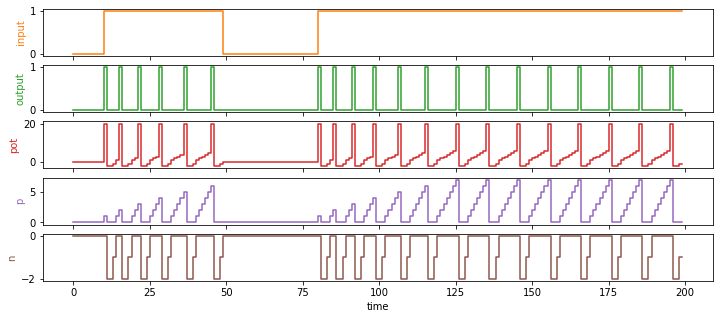

In [150]:
time=np.arange(0,200,1)
size = ((len(time)))
I=np.zeros(size)
O=np.zeros(size)

pot=np.zeros(size)
p=np.zeros(size)
n=np.zeros(size)


pos = 0
neg = 0

MASK = (1<<8)-1
NEGMASK = (1<<4)-1


THRESHOLD_BASE = 1
threshold = THRESHOLD_BASE
counter = 0

for t in time:

    pos = (pos << 1) & MASK
    neg = (neg << 1) & NEGMASK
    
    if (t > 10 and t < 50) or (t > 80):
        I[t]=1
        if ones(neg)==0:
            
            pos |= 1

    potential = ones(pos) - ones(neg)   
    p[t]=ones(pos)
    n[t]=-ones(neg)
    pot[t] = potential
    
    if counter == 1:
        threshold = max(THRESHOLD_BASE, threshold-1)
    elif counter > 0:
        counter -= 1
    if potential >= threshold:
        O[t]=1
        pos=0
        neg |= 3
        threshold += 1
        pot[t]=20
        counter = 10


plot(input=I, output=O, pot=pot,p=p, n=n)

# Quantative Potential

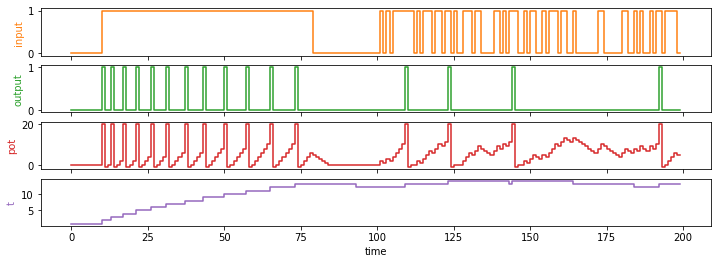

In [184]:
time=np.arange(0,200,1)
size = ((len(time)))
I=np.zeros(size)
O=np.zeros(size)

pot=np.zeros(size)
thrs=np.zeros(size)


THRESHOLD_MIN = 1
THRESHOLD_MAX = 20
RECOVERY = 20
DROP = -2

potential = 0
threshold = THRESHOLD_MIN
quiet_counter = 0


for t in time:
    
    quiet_counter += 1

    if (t > 10 and t < 80) or (t > 100 and r.random()>0.5):
        I[t]=1
        # react only if the potential is positive
        
    if I[t] and potential >=0:
        potential += 2
    elif potential > 0:
        potential -= 1
    elif potential < 0:
        potential +=1
       
  
    pot[t] = potential
    
        
    if potential >= threshold:
        O[t]=1
        potential = DROP
        threshold = min(threshold+1, THRESHOLD_MAX)
        pot[t]=20
        quiet_counter = 0
        
    if quiet_counter >=RECOVERY:
        quiet_counter = 0
        if threshold > THRESHOLD_MIN:
            threshold -=1
        
    thrs[t]=threshold
    


plot(input=I, output=O, pot=pot,t=thrs)

# Bit machine

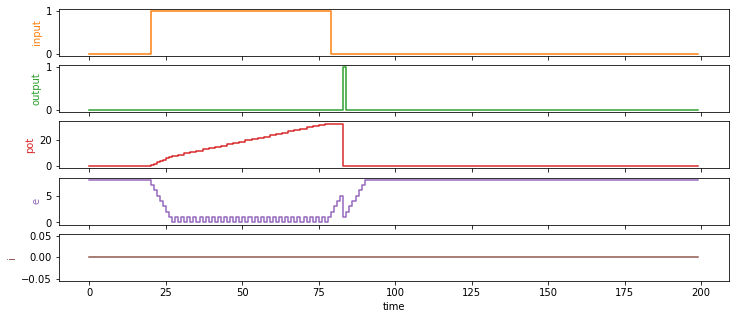

In [152]:
time=np.arange(0,200,1)
size = ((len(time)))
I=np.zeros(size)
O=np.zeros(size)
inbx = np.zeros(size)
pot=np.zeros(size)
e=np.zeros(size)


MAX_ENERGY = 8
energy = MAX_ENERGY

potential = 0

for t in time:
    
    inbox = 0
    energy_used = False
    
    if t > 20 and t< 80:
        inbox = 1
        
    I[t]=inbox
        
    if inbox and energy:
        energy -= 1
        energy_used = True
        potential += 1
   
    if potential > 4 and energy > 4:
        O[t]=1
        potential = 0
        energy = 0
    
    if not energy_used:
        energy = min(energy+1, MAX_ENERGY)

   
    pot[t]=potential
    e[t]=energy
    
    


plot(input=I, output=O, pot=pot,e=e, i=inbx)